In [1]:
%%capture
%pip install -U 'rockfish[labs]' -f 'https://packages.rockfish.ai'

In [2]:
import rockfish as rf
import rockfish.actions as ra
import rockfish.labs as rl
import warnings

warnings.filterwarnings("ignore")

Please replace `YOUR_API_KEY` with the assigned API key string. Note that it should be without quotes.

For example, if the assigned API Key is `abcd1234`, you can do the following

```python
%env ROCKFISH_API_KEY=abcd1234
conn = rf.Connection.from_env()
```

If you do not have API Key, please reach out to support@rockfish.ai.


In [ ]:
%env ROCKFISH_API_KEY=YOUR_API_KEY
conn = rf.Connection.from_env()

In [4]:
# download our example of timeseries data: pcap.csv
!wget --no-clobber https://docs.rockfish.ai/tutorials/pcap.csv

File ‘pcap.csv’ already there; not retrieving.



In [5]:
dataset = rf.Dataset.from_csv("DC pcap", "pcap.csv")
dataset.to_pandas()

,srcip,dstip,srcport,dstport,proto,timestamp,pkt_len
0,244.3.253.224,244.3.160.239,3396,80,6,2009-12-17 16:27:36.075494,40
1,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075515,1500
2,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075519,940
3,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075553,1500
4,41.177.26.91,68.157.168.194,80,65003,6,2009-12-17 16:27:36.075603,1500
...,...,...,...,...,...,...,...
95,68.157.168.194,41.177.26.91,45615,80,6,2009-12-17 16:27:36.099423,60
96,41.177.26.91,68.157.168.194,80,45615,6,2009-12-17 16:27:36.099891,64
97,41.177.3.203,41.177.3.224,58381,1791,6,2009-12-17 16:27:36.100508,40
98,244.3.41.84,244.3.31.67,2626,1592,6,2009-12-17 16:27:36.105025,237


In [ ]:
train_config = ra.TrainTimeTransformer.Config(
    encoder=ra.TrainTimeTransformer.DatasetConfig(
        timestamp=ra.TrainTimeTransformer.TimestampConfig(field="timestamp"),
        metadata=[
            ra.TrainTimeTransformer.FieldConfig(
                field="srcip", type="categorical"
            ),
            ra.TrainTimeTransformer.FieldConfig(
                field="dstip", type="categorical"
            ),
            ra.TrainTimeTransformer.FieldConfig(
                field="srcport", type="categorical"
            ),
            ra.TrainTimeTransformer.FieldConfig(
                field="dstport", type="categorical"
            ),
            ra.TrainTimeTransformer.FieldConfig(
                field="proto", type="categorical"
            ),
        ],
        measurements=[
            ra.TrainTimeTransformer.FieldConfig(field="pkt_len"),
        ],
    ),
    rtf=ra.TrainTimeTransformer.TrainConfig(
        num_bootstrap=2,
        parent=ra.TrainTimeTransformer.ParentConfig(
            epochs=1,
            gpt2_config=ra.TrainTimeTransformer.GPT2Config(
                layer=1, head=1, embed=1
            ),
        ),
        child=ra.TrainTimeTransformer.ChildConfig(
            epochs=1, output_max_length=2048
        ),
    ),
)
# create train action
train = ra.TrainTimeTransformer(train_config)

In [16]:
builder = rf.WorkflowBuilder()
builder.add_dataset(dataset)
builder.add_action(train, parents=[dataset])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 75S2AZxVU1SL34iK6va0ef


In [17]:
async for log in workflow.logs():
    print(log)

2025-02-27T23:24:52Z dataset-load: INFO Downloading dataset '26hHoPLs92KaH4gToL4Zsh'
2025-02-27T23:24:53Z dataset-load: INFO Downloaded dataset '26hHoPLs92KaH4gToL4Zsh' with 100 rows
2025-02-27T23:24:53Z train-time-transformer: INFO Start training...
2025-02-27T23:24:59Z train-time-transformer: INFO Epoch 1 completed.
2025-02-27T23:24:59Z train-time-transformer: INFO Start training relational model...
2025-02-27T23:25:32Z train-time-transformer: INFO Training completed. The Model ID is 21113308-f562-11ef-9da2-1a1838b36913


In [18]:
model = await workflow.models().last()
model

Model(id='21113308-f562-11ef-9da2-1a1838b36913', labels={'workflow_id': '75S2AZxVU1SL34iK6va0ef'}, create_time=datetime.datetime(2025, 2, 27, 23, 25, 28, tzinfo=datetime.timezone.utc), size_bytes=389512704)

In [ ]:
generate_config = ra.GenerateTimeTransformer.Config()
generate = ra.GenerateTimeTransformer(generate_config)
save = ra.DatasetSave(name="synthetic")
target = ra.SessionTarget(target=30)
builder = rf.WorkflowBuilder()
builder.add_model(model)
builder.add_action(generate, parents=[model, target])
builder.add_action(target, parents=[generate])
builder.add_action(save, parents=[generate])
workflow = await builder.start(conn)
print(f"Workflow: {workflow.id()}")

Workflow: 53B5VPmZ4tOM2BEAyEMH4h


In [39]:
async for log in workflow.logs():
    print(log)

2025-02-28T00:24:35Z generate-time-transformer: INFO Starting download of Model 21113308-f562-11ef-9da2-1a1838b36913
2025-02-28T00:24:54Z generate-time-transformer: INFO Finished download of Model 21113308-f562-11ef-9da2-1a1838b36913
2025-02-28T00:24:54Z generate-time-transformer: INFO Start generating samples...
2025-02-28T00:24:56Z generate-time-transformer: INFO Finish generating samples...
2025-02-28T00:24:57Z session-target: INFO Grouping on: ['session_key']
2025-02-28T00:24:57Z dataset-save: INFO using field 'session_key' to concatenate tables
2025-02-28T00:24:57Z session-target: INFO new=19 total=19 needs=11
2025-02-28T00:24:57Z generate-time-transformer: INFO Starting download of Model 21113308-f562-11ef-9da2-1a1838b36913
2025-02-28T00:24:57Z dataset-save: INFO Saved dataset '2PWWtvFU6WwFlFeIvsqNC7' with 154 rows
2025-02-28T00:25:23Z generate-time-transformer: INFO Finished download of Model 21113308-f562-11ef-9da2-1a1838b36913
2025-02-28T00:25:23Z generate-time-transformer: IN

In [40]:
syn = await workflow.datasets().concat(conn)
syn.to_pandas()

,srcip,dstip,srcport,dstport,proto,timestamp,pkt_len,session_key
0,41.177.241.46,41.177.3.224,190,1356,6,2009-12-17 16:27:36,1183,20
1,41.177.241.46,41.177.3.224,190,1356,6,2009-12-17 16:27:36,1140,20
2,41.177.241.46,41.177.3.224,190,1356,6,2009-12-17 16:27:36,441,20
3,41.177.241.46,41.177.3.224,190,1356,6,2009-12-17 16:27:36,1040,20
4,41.177.241.46,41.177.3.224,190,1356,6,2009-12-17 16:27:36,1574,20
...,...,...,...,...,...,...,...,...
242,244.3.153.25,244.3.31.67,8686,1853,6,2009-12-17 16:27:36,1643,19
243,244.3.153.25,244.3.31.67,8686,1853,6,2009-12-17 16:27:36,91,19
244,244.3.153.25,244.3.31.67,8686,1853,6,2009-12-17 16:27:36,1020,19
245,244.3.153.25,244.3.31.67,8686,1853,6,2009-12-17 16:27:36,40,19


# Evaluate the synthetic dataset


In [34]:
# assign metadata fields or session_key to both datasets in order to compute
# session related metrics
dataset = dataset.with_table_metadata(
    rf.TableMetadata(metadata="srcip dstip srcport dstport proto".split())
)
syn = syn.with_table_metadata(rf.TableMetadata(metadata=["session_key"]))

**Numerical columns**


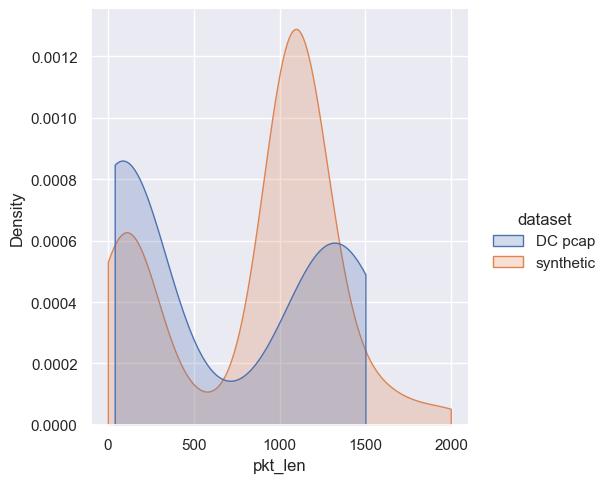

In [35]:
col = "pkt_len"
rf.labs.vis.plot_kde([dataset, syn], col)

**Categorical columns**


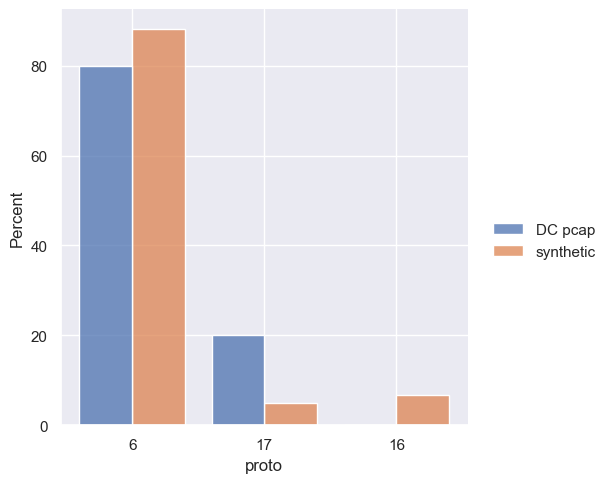

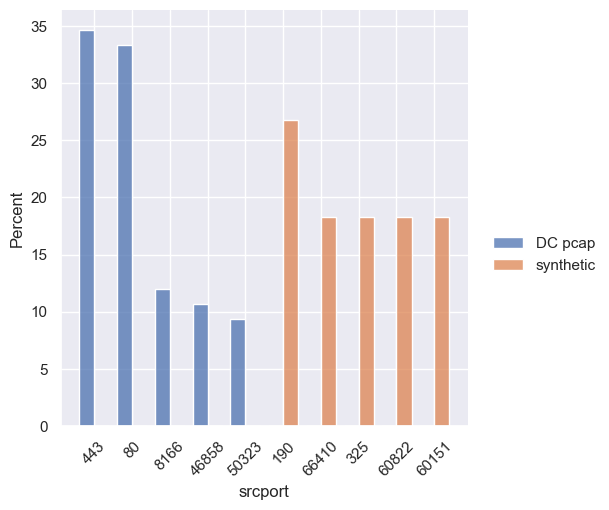

In [36]:
for col in ["proto", "srcport"]:
    source_agg = rf.metrics.count_all(dataset, col, nlargest=5)
    syn_agg = rf.metrics.count_all(syn, col, nlargest=5)
    rf.labs.vis.plot_bar([source_agg, syn_agg], col, f"{col}_count")